In [1]:
import torch
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Optional

In [2]:
def subplot_images(
    images: List[np.ndarray],
    titles: Optional[List[str]] = None,
    fig_size: tuple = (20, 10),
    dpi: int = 100,
    cmap: str = "gray",
    order: Tuple[int, int] = (1, -1),
) -> plt.Figure:
    """
    Subplot multiple images using matplotlib.

    Parameters:
        images (List[np.ndarray]): List of images to be plotted.
        titles (Optional[List[str]]): List of titles for the images. Default is None.
        fig_size (tuple): Figure size for the plot. Default is (20, 10).
        dpi (int): Dots per inch for the plot. Default is 100.
        cmap (str): Colormap to be used for the images. Default is 'gray'.
        order (Tuple[int, int]): Order of subplots (rows, columns). Use -1 to auto-calculate one dimension.

    Returns:
        plt.Figure: The matplotlib Figure object.
    """
    # Calculate subplot grid dimensions if one is set to -1
    if order[1] == -1:
        order = (order[0], (len(images) + order[0] - 1) // order[0])
    elif order[0] == -1:
        order = ((len(images) + order[1] - 1) // order[1], order[1])

    fig, axes = plt.subplots(order[0], order[1], figsize=fig_size, dpi=dpi)
    plt.tight_layout()

    # Flatten axes array for easy iteration, handling the case where axes is not 2D
    if order[0] == 1 or order[1] == 1:
        axes = np.atleast_1d(axes).flatten()
    else:
        axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            ax.axis("off")
            if titles:
                ax.set_title(titles[i], fontsize=12)
        else:
            ax.axis("off")  # Turn off axes for empty subplots

    plt.show()
    return fig


def show(
    image: np.ndarray, fig_size: tuple = (10, 10), cmap: str = "gray", title: str = None
):
    """
    Display an image using matplotlib.
    """
    plt.figure(figsize=fig_size)
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

In [3]:
expt_dirs = [
['/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_dice_2024-08-04'],
['/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_focal_2024-08-04']
]

In [4]:
import json
import pandas as pd

expt_res=[]
for expts in expt_dirs:
    logs = pd.DataFrame(columns=['epoch'])
    for expt in expts:
        expt = Path(expt)
        for json_file in expt.rglob('*.json'):
            print(json_file)
            if 'config' in json_file.name:
                continue
            with open(json_file ) as f:
                data = json.load(f)
                for epoch, data in data.items():
                    # if int(epoch)>150 or int(epoch) in logs.epoch.values:
                    #     continue
                    epoch = int(epoch)
                    for k,v in data.items():
                        logs.loc[epoch, k] = float(v)
                    logs.loc[epoch, 'epoch'] = epoch
                    logs.loc[epoch, 'expt'] = str(json_file)
    logs = logs.sort_values(by='epoch')
    expt_res.append(logs)

/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_dice_2024-08-04/config.json
/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_dice_2024-08-04/0_0_logs.json
/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_dice_2024-08-04/0_149_logs.json
/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_focal_2024-08-04/config.json
/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_focal_2024-08-04/0_0_logs.json
/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_focal_2024-08-04/0_149_logs.json


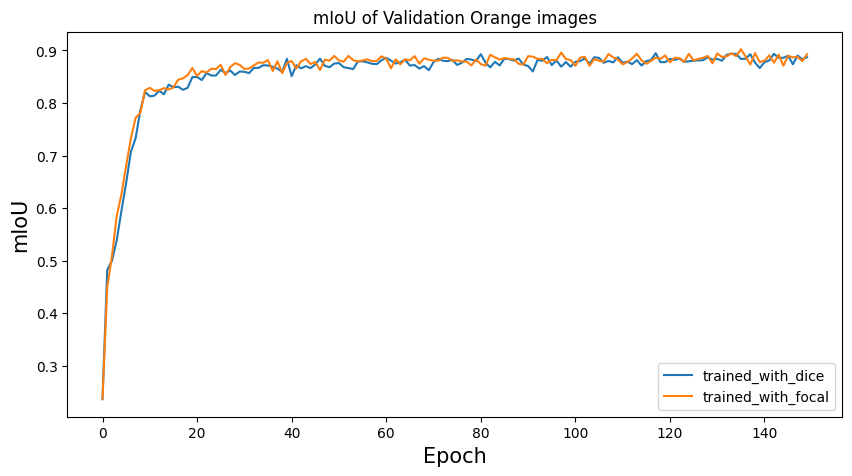

In [51]:
fig=plt.figure(figsize=(10,5))
for i, logs in enumerate(expt_res):
    bg_ious = np.array(logs['valid_orange_iou'])
    or_ious = np.array(logs['valid_orange_iou'])
    ious = 0.5*(bg_ious+or_ious)

    expt=logs.expt[0].split('/')[-2]
    expt = 'trained_with_dice' if 'dice' in expt else 'trained_with_focal'
    miou = or_ious.mean()
    # $f' best mIoU: {miou:.3f}'
    plt.plot(logs.epoch, or_ious, label=expt)

plt.title(f"mIoU of Validation Orange images")
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('mIoU', fontsize=15)
plt.legend(fontsize=10)
fig.savefig('iou_unet.pdf')
plt.show()

In [11]:
def get_best_model(expt_res):
    best_res = []
    
    for logs in expt_res:
        # val_loss_col = [col for col in logs.columns if 'val' in col and 'loss' in col][0]
        min_loss = logs['valid_iou_score'].max()
        # print(val_loss_col, min_loss)
        best_expt = logs[logs['valid_iou_score']==min_loss].expt.values[0].replace('_logs.json', '_best_model.pth')
        best_res.append(best_expt)
    return best_res

best_models = get_best_model(expt_res)
best_models

['/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_dice_2024-08-04/0_149_best_model.pth',
 '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_focal_2024-08-04/0_149_best_model.pth']

In [7]:
from segmentation_models_pytorch.utils.base import Metric
import segmentation_models_pytorch.utils.functional as smp_f
import torch.nn.functional as F
class IoU(Metric):
    __name__ = "iou_score"
    def __init__(
        self, eps=1e-7, threshold=0.5, ignore_channels=None, **kwargs
    ):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):        
        one_hot_target = F.one_hot(y_gt, y_pr.size(1))  # Shape: (N, H, W, C)
        one_hot_target = one_hot_target.permute(0, 3, 1, 2).contiguous()  # Shape: (N, C, H, W)       
        return smp_f.iou(
            y_pr,
            one_hot_target,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
    
    def forward_each_class(self, y_pr, y_gt):
        one_hot_target = F.one_hot(y_gt, y_pr.size(1))  # Shape: (N, H, W, C)
        one_hot_target = one_hot_target.permute(0, 3, 1, 2).contiguous()  # Shape: (N, C, H, W)
        
        ious=[]
        for c in range(one_hot_target.size(1)):
            ious.append(smp_f.iou(
                y_pr[:,c,:,:],
                one_hot_target[:,c,:,:],
                eps=self.eps,
                threshold=self.threshold,
                ignore_channels=self.ignore_channels,
            ))
        return torch.tensor(ious)
iou_obj=IoU()

/apps/jupyterhub/jh3.1.1-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import torch.nn.functional as F
def get_ious(masks, outputs, iou_obj):
    ious = []
    for output, mask in zip(outputs, masks):
        iou = iou_obj.forward_each_class(output.unsqueeze(0), mask.unsqueeze(0))
        ious.append(iou)
    return np.array(ious)

def overlay_mask(image, mask, alpha=0.5, color=[0, 0, 255]):
    """
    Overlay a mask on an image.
    """
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 255] = color
    return cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

def compare_results(image, mask, output):
    
    images = image.unsqueeze(0)
    masks = mask.unsqueeze(0)
    
    # Forward pass through the model
    outputs = output.unsqueeze(0)
    one_hot_target = F.one_hot(masks, outputs.size(1))  # Shape: (N, H, W, C)
    # print(one_hot_target.size())
    masks = one_hot_target.permute(0, 3, 1, 2).contiguous()  # Shape: (N, C, H, W)

    # Convert tensors to numpy arrays for plotting
    image_np = images.squeeze(0).cpu().permute(1, 2, 0).detach().numpy().astype(np.uint8)
    true_mask_np = 255*masks.squeeze(0).cpu().detach().numpy()
    pred_mask_np = 255*(outputs.squeeze(0).cpu().numpy()>0.5)

        
    # Define epsilon to avoid division by zero
    epsilon = 1e-6

    # Convert masks to boolean
    # but inverse the background mask
    true_bool = true_mask_np[1] ==255
    pred_bool = pred_mask_np[1] ==255

    # Calculate intersection and union
    intersection = np.logical_and(true_bool, pred_bool)
    union = np.logical_or(true_bool, pred_bool)

    # Compute IoU with epsilon to prevent division by zero
    iou = np.sum(intersection) / (np.sum(union) + epsilon)

    alpha = 0.5
    true_overlay = overlay_mask(image_np.copy(), true_mask_np[1], alpha=alpha, color=[100, 0, 200])
    # true_overlay = overlay_mask(true_overlay, true_mask_np[2], alpha=alpha, color=[255, 0, 0])
    pred_overlay = overlay_mask(image_np.copy(), pred_mask_np[1], alpha=alpha, color=[100, 0, 200])
    # pred_overlay = overlay_mask(pred_overlay, pred_mask_np[2], alpha=alpha, color=[255, 0, 0])
    # orange_overlay = overlay_mask(image_np.copy(), 255-pred_mask_np[0], alpha=alpha, color=[255, 0, 0])
    # orange_true_overlay = overlay_mask(image_np.copy(), 255-true_mask_np[0], alpha=alpha, color=[255, 0, 0])

    return image_np, true_overlay, pred_overlay, iou

In [42]:
import sys
from tqdm import tqdm
sys.path.append('/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation')
from trainer_binary_focal import DataLoader, DataSet, DataLabels, get_train_transforms, get_test_transforms

iou_threshold = 0.001

best_models = [
                '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_dice_2024-08-04/0_143_best_model.pth',
               '/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/slurm_binary_focal_2024-08-04/0_74_best_model.pth'
               ]
test_ious = {}
test_res = {}
for best_model in best_models:
    best_model = Path(best_model)
    out_dir = best_model.parent / 'out_images'
    out_dir.mkdir(exist_ok=True)
    test_ious[best_model] = []

    with open(best_model.parent / 'config.json') as f:
        CONFIGS = json.load(f)  
    data_labels = DataLabels(root_dir=CONFIGS['data_dir'], 
                                labels_file=CONFIGS['labels_dir'], 
                                split_ratio=CONFIGS['train_size'],
                                max_samples=-100,
                                shuffle_seed=CONFIGS['shuffle_seed'])

    train_transform = get_train_transforms(height=CONFIGS['height'], width=CONFIGS['width'])
    test_transform = get_test_transforms(height=CONFIGS['height'], width=CONFIGS['width'])

    train_dataset = DataSet(kind=1, data_labels=data_labels, transform=train_transform)
    test_dataset = DataSet(kind=0, data_labels=data_labels, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=CONFIGS['batch_size'], shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, 
                             batch_size=32, #CONFIGS['batch_size'], 
                             shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # print(best_model, device)
    model = torch.load(best_model, map_location=device)
    model = model.to(device)
    model.eval()

    best_iou = 0
    worst_iou = 1
    best_image = None
    worst_image = None
    # pbar = tqdm(len(test_loader))
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            # outputs[:, 0] = 1-outputs[:, 0]
            ious = get_ious(masks, outputs, iou_obj)
            # outputs[:, 0] = 1-outputs[:, 0]

            for j, (image, mask, output, iou) in enumerate(zip(images, masks, outputs, ious)):
                # oiou=iou[0]
                image_np, true_overlay, pred_overlay, oiou = compare_results(image, mask, output)
                oiou = iou[1]
                if oiou>best_iou:
                    best_iou = oiou
                    best_image = [true_overlay, pred_overlay]

                if oiou<worst_iou:
                    worst_iou = oiou
                    worst_image = [true_overlay, pred_overlay]
                test_ious[best_model].append(oiou) 
                test_res[best_model]=[best_image, worst_image]
                # cv2.imwrite(str(out_dir / f'{i}_{j}_true.png'), cv2.cvtColor(true_overlay, cv2.COLOR_RGB2BGR))
                # cv2.imwrite(str(out_dir / f'{i}_{j}_pred.png'), cv2.cvtColor(pred_overlay, cv2.COLOR_RGB2BGR))
                # cv2.imwrite(str(out_dir / f'{i}_{j}_orange.png'), cv2.cvtColor(orange_overlay, cv2.COLOR_RGB2BGR))

            # break

    

/tmp/ipykernel_1106958/2464007701.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(best_model, map_location=device)


In [30]:
def iou_score(predicted_mask, ground_truth_mask):
    intersection = torch.logical_and(predicted_mask, ground_truth_mask).sum()
    union = torch.logical_or(predicted_mask, ground_truth_mask).sum()
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

iou_score(outputs[1][1]>0.5, masks[1]>0)

0.7721846103668213

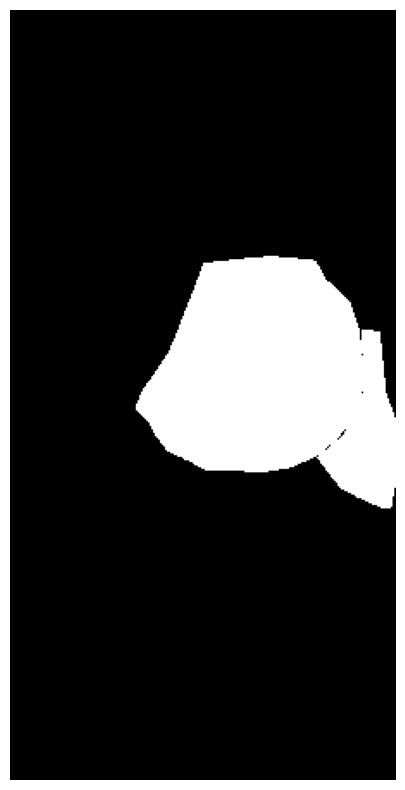

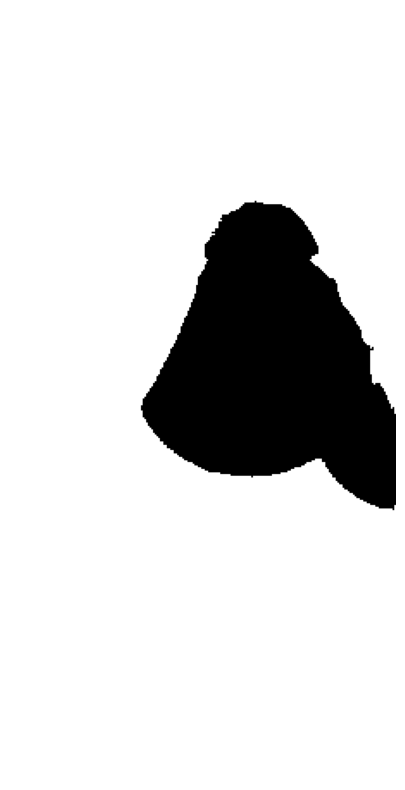

In [26]:
show(masks[0].cpu().numpy())
show((outputs[0][0]>0.5).cpu().numpy())

In [43]:
# get_ious(masks, outputs, iou_obj)

In [44]:
# subplot_images(best_image, titles=['True', f'Predicted: {oiou:.2f}'], fig_size=(10,10)).savefig(str(out_dir / f'{oiou :.2f}_{i}_{j}_best.pdf'))
# subplot_images(worst_image, titles=['True', f'Predicted: {oiou:.2f}'], fig_size=(10,10)).savefig(str(out_dir / f'{oiou:.2f}_{i}_{j}_worst.pdf'))


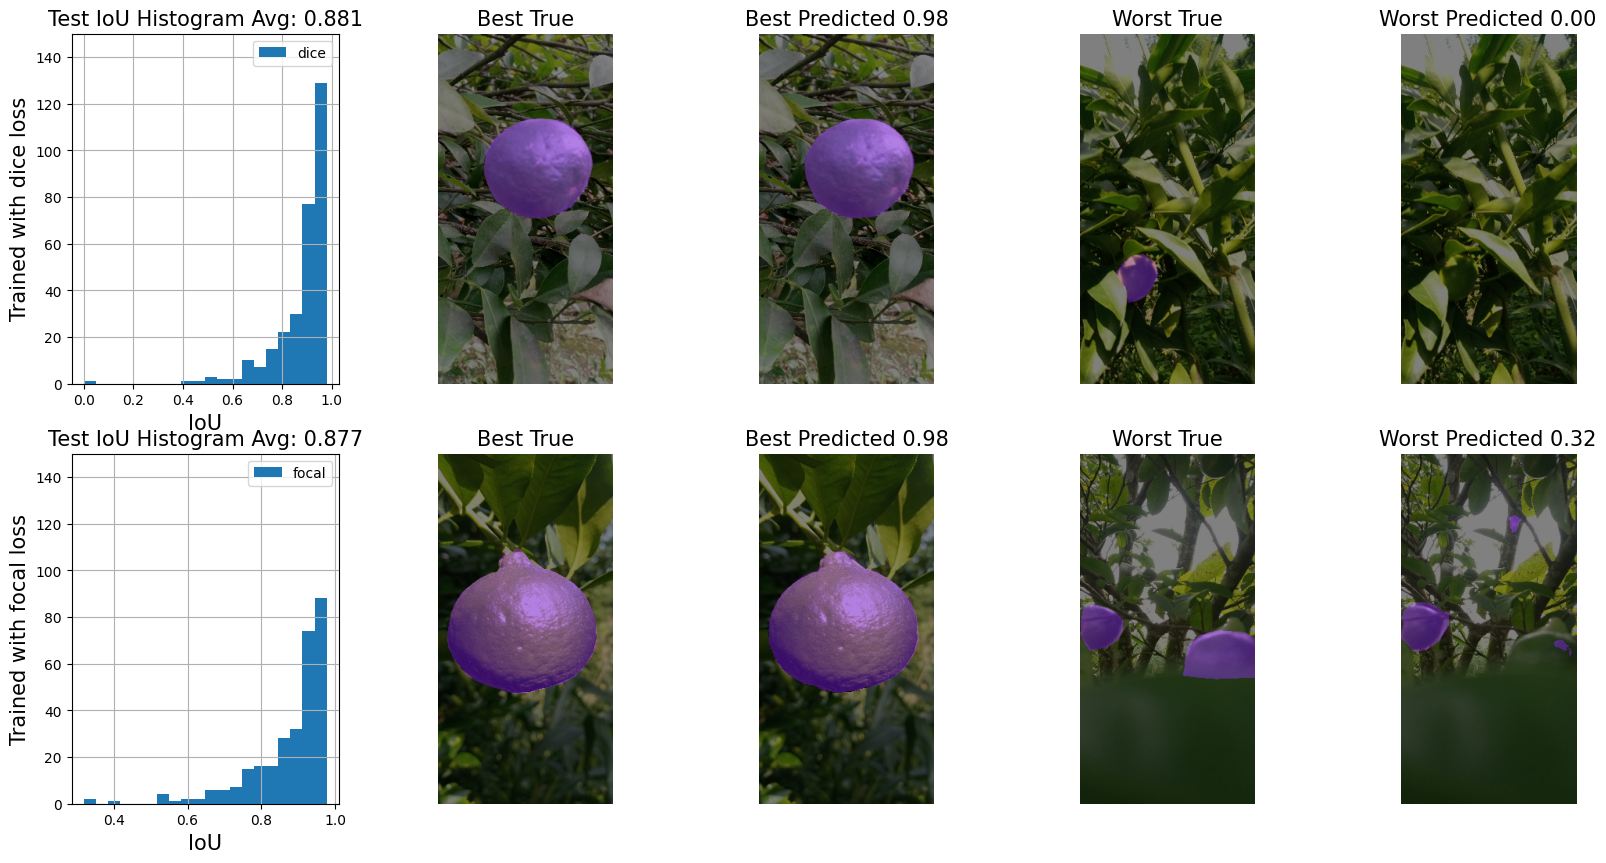

In [45]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

r=0
for bm,val in test_ious.items():
    name = 'focal' if 'focal' in str(bm) else 'dice'
    ious = np.array(val)
    axes[r,0].hist(ious, bins=20, label=name)
    axes[r,0].set_title('Test IoU Histogram Avg: {:.3f}'.format(ious.mean()), fontsize=15)
    axes[r,0].set_xlabel('IoU', fontsize=15)
    axes[r,0].set_ylabel(f'Trained with {name} loss', fontsize=15)
    axes[r,0].grid(True)
    axes[r,0].legend()
    axes[r,0].set_ylim(0, 150)

    best_image, worst_image = test_res[bm]
    axes[r,1].imshow(best_image[0])
    axes[r, 2].imshow(best_image[1])
    axes[r,1].set_title('Best True',fontsize=15)
    axes[r,2].set_title('Best Predicted {0:.2f}'.format(ious.max()),fontsize=15)
    axes[r,1].axis('off')
    axes[r,2].axis('off')

    axes[r,3].imshow(worst_image[0])
    axes[r, 4].imshow(worst_image[1])
    axes[r,3].set_title('Worst True',fontsize=15)
    axes[r,4].set_title('Worst Predicted {0:.2f}'.format(ious.min()),fontsize=15)
    axes[r,3].axis('off')
    axes[r,4].axis('off')
    r+=1
fig.savefig('unet_comparison.pdf')
plt.show()


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [2]:
import sys
sys.path.append('/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation')
from trainer import DataLoader, DataSet, DataLabels, get_train_transforms, get_test_transforms

data_labels = DataLabels(root_dir='/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/Orange_Image_Data',
           labels_file='/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/project-4-at-2024-03-02-15-13-497758b6.json')

/apps/python/3.10-anaconda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [4]:
len(data_labels.train_idx), len(data_labels.valid_idx)

(1196, 300)

In [35]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class DataLabels:
    def __init__(self, root_dir, labels_file, shuffle_seed=42, split_ratio=0.8, max_samples=-1):
        """
        root_dir: From where all dataset is being read.
        labels_file: Labels file path.
        shuffle_seed: to handle random split.
        split_ratio: first half train, second will be test
        max_samples: max number of samples to take. -1 means all.
        """
        self.root_dir = root_dir
        self.labels_file = labels_file
        self.images_dir = root_dir
        self.shuffle_seed = shuffle_seed
        self.split_ratio = split_ratio
        self.max_samples = max_samples
        
        self.labels, self.label_counts = self.load_labels(labels_file)
        np.random.seed(shuffle_seed)
        fnames = list(self.labels.keys())
        np.random.shuffle(fnames)
        self.idxs = list(range(len(fnames)))
        self.labels = {k: self.labels[k] for k in fnames}
        self.train_idx = self.idxs[:int(len(self.labels) * split_ratio)]
        self.valid_idx = self.idxs[len(self.train_idx):]
        self.train_labels = {fnames[k]: self.labels[fnames[k]] for k in self.train_idx}
        self.valid_labels = {fnames[k]: self.labels[fnames[k]] for k in self.valid_idx}

    def load_labels(self, labels_dir):
        # Load segmentation labels from JSON file
        with open(labels_dir, 'r') as f:
            segmentation_data = json.load(f)

        final_labels = {}
        label_counts = {}
        self.label_names = []
        img_cnts = 0

        for sm in segmentation_data:
            img_name = "IMG" + sm['image'].split('-IMG')[1]
            img_dict = {}

            if sm.get('label') is None:
                continue

            for labels in sm['label']:
                width = labels['original_width']
                height = labels['original_height']
                points = np.array(labels['points']).reshape(-1, 2)
                points[:, 0] = points[:, 0] * width / 100
                points[:, 1] = points[:, 1] * height / 100

                label_names = labels['polygonlabels']

                for label_name in label_names:
                    self.label_names.append(label_name)
                    if img_dict.get(label_name) is None:
                        img_dict[label_name] = []
                    img_dict[label_name].append(points)

            final_labels[img_name] = img_dict
            label_counts[img_name] = {k: len(v) for k, v in img_dict.items()}
            img_cnts += 1
            
            if img_cnts >= self.max_samples and self.max_samples > 0:
                break

        self.label_names = sorted(list(set(self.label_names)))
        return final_labels, label_counts

class DataSet(Dataset):
    def __init__(self, kind=1, data_labels=None, transform=None, 
                 color_space="RGB", multiclass=True):
        """
        kind: 1 for training and 0 for validation.
        data_labels: dictionary containing labels.
        transform: what transformation to apply.
        color_space: rgb/hsv or any other.
        multiclass: if True, target will be N,H,W else, N,C,H,W
        """
        self.data_labels = data_labels
        self.color_space=color_space
        self.transform = transform
        self.multiclass = multiclass
        # 1 for train, 0 for valid
        if kind == 1:
            self.curr_labels = self.data_labels.train_labels
        else:
            self.curr_labels = self.data_labels.valid_labels

    def __len__(self):
        return len(self.curr_labels)

    def __getitem__(self, idx):
        img_name = list(self.curr_labels.keys())[idx]
        img_path = os.path.join(self.data_labels.images_dir, img_name)

        # Load image
        image = Image.open(img_path).convert(self.color_space)
        image = np.array(image)

        # Create masks for each class label
        background = np.zeros(image.shape[:2], dtype=np.uint8) + 255
        healthy = np.zeros(image.shape[:2], dtype=np.uint8)
        infected = np.zeros(image.shape[:2], dtype=np.uint8)
        
        masks_dict = {"Background": background, "Healthy": healthy, "Infected": infected}
        
        for label_name, points_list in self.curr_labels[img_name].items():
            mask = masks_dict.get(label_name)

            # Draw each mask on the blank mask
            for points in points_list:
                points = np.round(points).astype(int)
                mask = cv2.fillPoly(mask, [points], 255)
                background = cv2.fillPoly(background, [points], 0)

            masks_dict[label_name] = mask
        background = background
        
        masks = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        masks[:, :, 0] = masks_dict["Background"]
        masks[:, :, 1] = masks_dict["Healthy"]
        masks[:, :, 2] = masks_dict["Infected"]

        if self.transform:
            augmented = self.transform(image=image, masks=masks)
            image = augmented['image']
            masks = augmented['masks']
        if self.multiclass:
            # for multiclass we need mask in format N, H, W. Each value in it represents class value.
            # class should start from 0.
            nmasks = np.zeros((masks.shape[0], masks.shape[1]))
            nmasks[(masks[:, :, 1] + masks[:, :, 2])>0] = 1
            # nmasks[masks[:, :, 2]>0] = 2
            masks=torch.tensor(nmasks).long()
        return image.float(), masks

# dataset and dataloader
data_labels = DataLabels(root_dir=CONFIGS['data_dir'], 
                    labels_file=CONFIGS['labels_dir'], 
                    split_ratio=CONFIGS['train_size'],
                    max_samples=-100,
                    shuffle_seed=CONFIGS['shuffle_seed'])

train_transform = get_train_transforms(height=CONFIGS['height'], width=CONFIGS['width'])
test_transform = get_test_transforms(height=CONFIGS['height'], width=CONFIGS['width'])

train_dataset = DataSet(kind=1, data_labels=data_labels, transform=train_transform)

test_dataset = DataSet(kind=0, data_labels=data_labels, transform=test_transform)

In [36]:
for img, masks in test_dataset:
    break


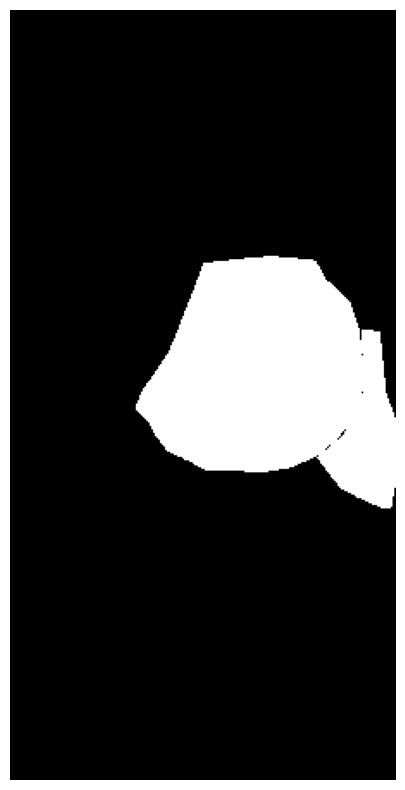

In [37]:
show(255*(masks==1).numpy().astype(np.uint8))